In [1]:
#!pip install torch torchvision
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = trainloader.dataset.classes

Files already downloaded and verified
Files already downloaded and verified


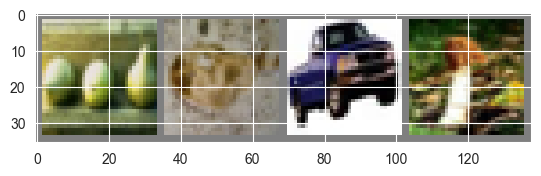

pear  ray   pickup_truck mushroom


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=100, bias=True)
)

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
for epoch in range(8):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 4.603
[1,  4000] loss: 4.505
[1,  6000] loss: 4.422
[1,  8000] loss: 4.330
[1, 10000] loss: 4.220
[1, 12000] loss: 4.065
[2,  2000] loss: 3.895
[2,  4000] loss: 3.810
[2,  6000] loss: 3.732
[2,  8000] loss: 3.638
[2, 10000] loss: 3.556
[2, 12000] loss: 3.519
[3,  2000] loss: 3.411
[3,  4000] loss: 3.379
[3,  6000] loss: 3.374
[3,  8000] loss: 3.353
[3, 10000] loss: 3.299
[3, 12000] loss: 3.292
[4,  2000] loss: 3.182
[4,  4000] loss: 3.187
[4,  6000] loss: 3.179
[4,  8000] loss: 3.176
[4, 10000] loss: 3.135
[4, 12000] loss: 3.165
[5,  2000] loss: 3.022
[5,  4000] loss: 3.073
[5,  6000] loss: 3.089
[5,  8000] loss: 3.061
[5, 10000] loss: 3.072
[5, 12000] loss: 3.017
[6,  2000] loss: 2.953
[6,  4000] loss: 2.956
[6,  6000] loss: 2.980
[6,  8000] loss: 2.983
[6, 10000] loss: 3.006
[6, 12000] loss: 2.962
[7,  2000] loss: 2.843
[7,  4000] loss: 2.877
[7,  6000] loss: 2.897
[7,  8000] loss: 2.960
[7, 10000] loss: 2.898
[7, 12000] loss: 2.948
[8,  2000] loss: 2.816
[8,  4000] 

In [12]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

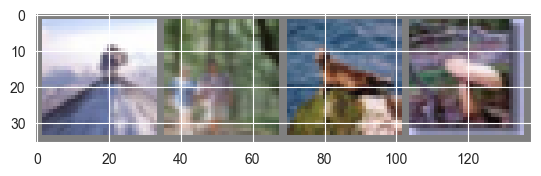

GroundTruth:  mountain forest seal  mushroom


In [13]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [14]:
# Predict
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [15]:
outputs = net(images)

In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  tank  kangaroo camel mushroom


In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 25 %


In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: apple is 45.0 %
Accuracy for class: aquarium_fish is 43.0 %
Accuracy for class: baby  is 15.0 %
Accuracy for class: bear  is 11.0 %
Accuracy for class: beaver is 2.0 %
Accuracy for class: bed   is 21.0 %
Accuracy for class: bee   is 33.0 %
Accuracy for class: beetle is 30.0 %
Accuracy for class: bicycle is 25.0 %
Accuracy for class: bottle is 26.0 %
Accuracy for class: bowl  is 6.0 %
Accuracy for class: boy   is 10.0 %
Accuracy for class: bridge is 15.0 %
Accuracy for class: bus   is 17.0 %
Accuracy for class: butterfly is 12.0 %
Accuracy for class: camel is 4.0 %
Accuracy for class: can   is 17.0 %
Accuracy for class: castle is 46.0 %
Accuracy for class: caterpillar is 26.0 %
Accuracy for class: cattle is 23.0 %
Accuracy for class: chair is 33.0 %
Accuracy for class: chimpanzee is 19.0 %
Accuracy for class: clock is 10.0 %
Accuracy for class: cloud is 52.0 %
Accuracy for class: cockroach is 56.0 %
Accuracy for class: couch is 14.0 %
Accuracy for class: crab  is 15.